In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import random
import time
from torch.utils.data import random_split


In [12]:

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)


Device in use: cuda:0


In [13]:

# Define the neural network architecture
class MLP(nn.Module):
    def __init__(self, use_batch_norm=False):
        super(MLP, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.fc1 = nn.Linear(32 * 32 * 3, 500)
        self.fc2 = nn.Linear(500, 250)
        self.fc3 = nn.Linear(250, 100)
        self.fc4 = nn.Linear(100, 10)
        if self.use_batch_norm:
            self.bn1 = nn.BatchNorm1d(500)
            self.bn2 = nn.BatchNorm1d(250)
            self.bn3 = nn.BatchNorm1d(100)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = torch.relu(self.fc1(x))
        if self.use_batch_norm:
            x = self.bn1(x)
        x = torch.relu(self.fc2(x))
        if self.use_batch_norm:
            x = self.bn2(x)
        x = torch.relu(self.fc3(x))
        if self.use_batch_norm:
            x = self.bn3(x)
        x = self.fc4(x)
        return x


# Load CIFAR-10 dataset and normalize it
def load_data():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
    
    full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    
    # Split the dataset into training and validation sets
    train_size = int(0.8 * len(full_trainset))
    val_size = len(full_trainset) - train_size

    trainset, valset = random_split(full_trainset, [train_size, val_size])
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

    valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False)
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)
    
    return trainloader, valloader, testloader, testset

# Function to train the network
def train_network(trainloader, valloader, use_batch_norm=False, n_epoch=2):
    start_time = time.time()
    net = MLP(use_batch_norm=use_batch_norm)
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []

    for epoch in range(n_epoch):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        net.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct_train / total_train
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)

        val_loss = 0.0
        correct_val = 0
        total_val = 0
        net.eval()
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)

                outputs = net(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(valloader)
        val_accuracy = 100 * correct_val / total_val
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)

        

        print(f'Epoch {epoch + 1:2d} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%')
    end_time = time.time()
    training_time = end_time - start_time
    print(f'Training time: {training_time//60:.0f} minutes, {training_time%60:.0f} seconds')
    # print('Training complete in {:.0f}m {:.0f}s'.format(training_time // 60, training_time % 60))

    return net, train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list

# Function to plot training and validation loss
def plot_loss(train_loss_list, val_loss_list):
    plt.figure(figsize=(8, 6))
    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Function to plot training and validation accuracy
def plot_accuracy(train_accuracy_list, val_accuracy_list):
    plt.figure(figsize=(8, 6))
    plt.plot(train_accuracy_list, label='Training Accuracy')
    plt.plot(val_accuracy_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Function to plot randomly selected test images with true and predicted labels
def plot_random_test_images(model, testloader, testset):
    images, labels = next(iter(testloader))
    indices = random.sample(range(len(images)), 5)
    selected_images = images[indices].to(device)
    selected_labels = labels[indices]

    model.eval()
    with torch.no_grad():
        outputs = model(selected_images)
        _, predicted = torch.max(outputs, 1)
    
    predicted_labels = predicted.cpu().numpy()

    plt.figure(figsize=(10, 2))
    for i in range(len(selected_images)):
        image = selected_images[i].cpu().permute(1, 2, 0).numpy()
        image = image / 2 + 0.5  # Unnormalize
        plt.subplot(1, 5, i + 1)
        plt.imshow(image)
        plt.title(f'True: {testset.classes[selected_labels[i]]}\nPred: {testset.classes[predicted_labels[i]]}')
        plt.axis('off')
    plt.show()

# Function to compute and plot confusion matrix
def plot_confusion_matrix(model, testloader, classes):
    all_labels = []
    all_preds = []
    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Function to evaluate the model
def evaluate_model(model, testloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy


In [14]:

# Load the dataset
trainloader, valloader, testloader, testset = load_data()


Files already downloaded and verified
Files already downloaded and verified


In [15]:
# Train and evaluate the network without batch normalization
print("Training the model without Batch Normalization")
model, train_loss, val_loss, train_acc, val_acc = train_network(trainloader, valloader, use_batch_norm=False, n_epoch=25)


Training the model without Batch Normalization
Epoch  1 | Train Loss: 2.2804 | Train Acc: 16.74% | Val Loss: 2.2471 | Val Acc: 19.92%
Epoch  2 | Train Loss: 2.1750 | Train Acc: 22.32% | Val Loss: 2.0938 | Val Acc: 25.09%
Epoch  3 | Train Loss: 2.0286 | Train Acc: 27.16% | Val Loss: 1.9676 | Val Acc: 30.12%
Epoch  4 | Train Loss: 1.9259 | Train Acc: 30.94% | Val Loss: 1.8822 | Val Acc: 33.12%
Epoch  5 | Train Loss: 1.8491 | Train Acc: 33.80% | Val Loss: 1.8141 | Val Acc: 36.22%
Epoch  6 | Train Loss: 1.7847 | Train Acc: 36.41% | Val Loss: 1.7581 | Val Acc: 37.41%
Epoch  7 | Train Loss: 1.7299 | Train Acc: 38.26% | Val Loss: 1.7089 | Val Acc: 39.24%
Epoch  8 | Train Loss: 1.6823 | Train Acc: 39.96% | Val Loss: 1.6682 | Val Acc: 40.90%
Epoch  9 | Train Loss: 1.6409 | Train Acc: 41.47% | Val Loss: 1.6362 | Val Acc: 41.81%
Epoch 10 | Train Loss: 1.6045 | Train Acc: 42.77% | Val Loss: 1.6069 | Val Acc: 43.05%
Epoch 11 | Train Loss: 1.5693 | Train Acc: 44.19% | Val Loss: 1.5817 | Val Acc: 44.

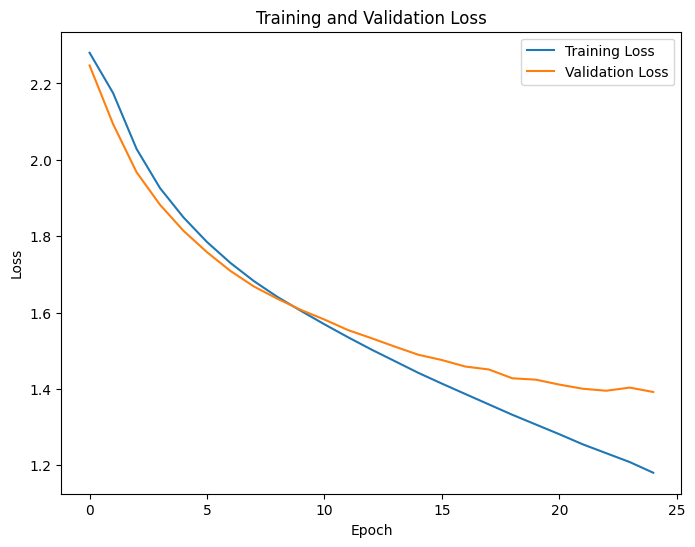

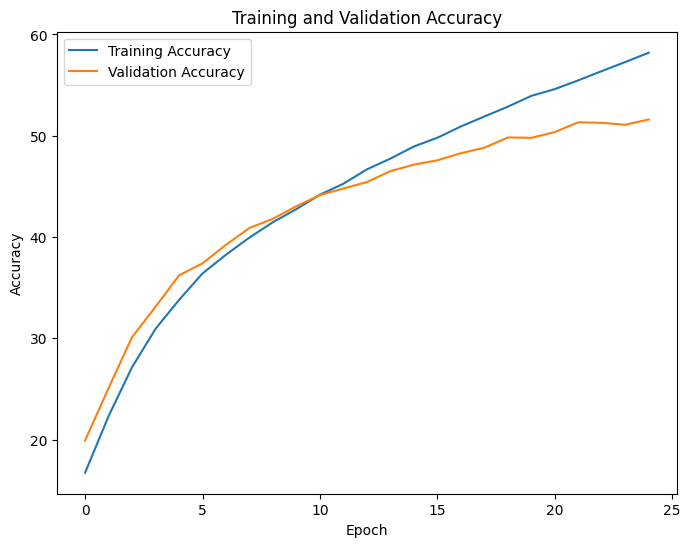

In [16]:
plot_loss(train_loss, val_loss)

plot_accuracy(train_acc, val_acc)


In [17]:

print("Evaluating the model without Batch Normalization")
test_accuracy = evaluate_model(model, testloader)

print(f'Test Accuracy without Batch Normalization: {test_accuracy:.2f}%')
print("Random test images and predictions without Batch Normalization:")


Evaluating the model without Batch Normalization
Test Accuracy: 51.60%
Test Accuracy without Batch Normalization: 51.60%
Random test images and predictions without Batch Normalization:


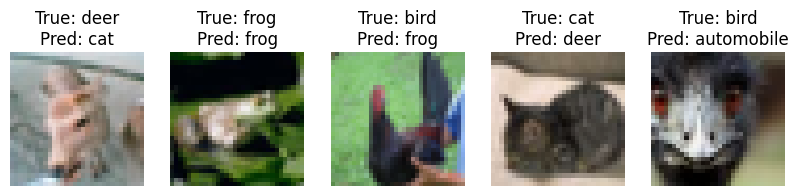

In [18]:
plot_random_test_images(model, testloader, testset)

Confusion Matrix without Batch Normalization:


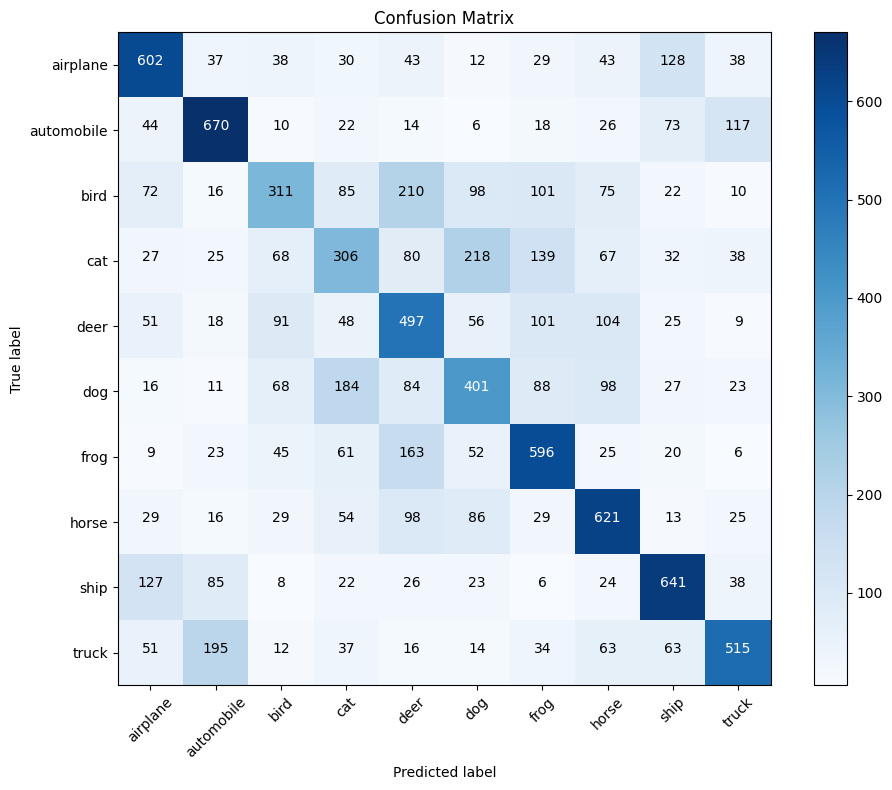

In [19]:
print("Confusion Matrix without Batch Normalization:")
plot_confusion_matrix(model, testloader, testset.classes)

Training the model with Batch Normalization
Epoch  1 | Train Loss: 1.6997 | Train Acc: 39.77% | Val Loss: 1.5437 | Val Acc: 45.13%
Epoch  2 | Train Loss: 1.4390 | Train Acc: 49.42% | Val Loss: 1.4582 | Val Acc: 47.84%
Epoch  3 | Train Loss: 1.3096 | Train Acc: 54.09% | Val Loss: 1.4192 | Val Acc: 49.74%
Epoch  4 | Train Loss: 1.2140 | Train Acc: 57.46% | Val Loss: 1.3798 | Val Acc: 51.57%
Epoch  5 | Train Loss: 1.1285 | Train Acc: 60.87% | Val Loss: 1.3776 | Val Acc: 50.96%
Epoch  6 | Train Loss: 1.0524 | Train Acc: 63.45% | Val Loss: 1.3731 | Val Acc: 51.39%
Epoch  7 | Train Loss: 0.9754 | Train Acc: 66.15% | Val Loss: 1.3839 | Val Acc: 52.14%
Epoch  8 | Train Loss: 0.9126 | Train Acc: 68.44% | Val Loss: 1.3891 | Val Acc: 52.49%
Epoch  9 | Train Loss: 0.8414 | Train Acc: 71.10% | Val Loss: 1.4163 | Val Acc: 52.10%
Epoch 10 | Train Loss: 0.7741 | Train Acc: 73.68% | Val Loss: 1.4315 | Val Acc: 52.32%
Epoch 11 | Train Loss: 0.7150 | Train Acc: 75.89% | Val Loss: 1.4774 | Val Acc: 51.95%

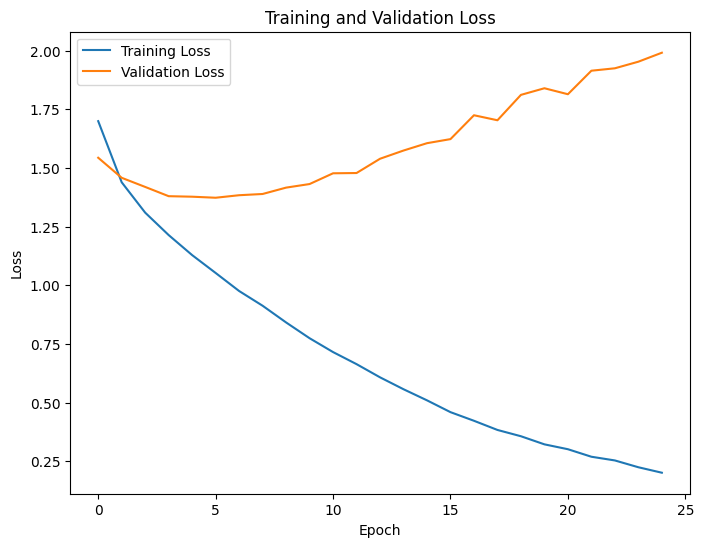

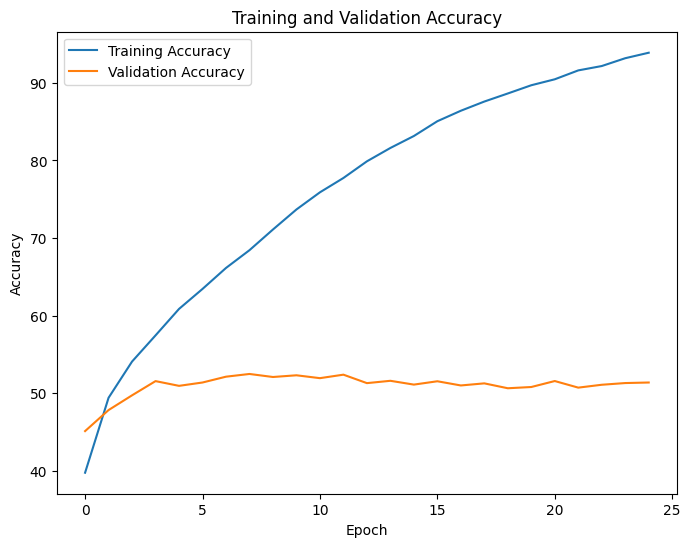

Evaluating the model with Batch Normalization
Test Accuracy: 50.86%
Test Accuracy with Batch Normalization: 50.86%
Random test images and predictions with Batch Normalization:


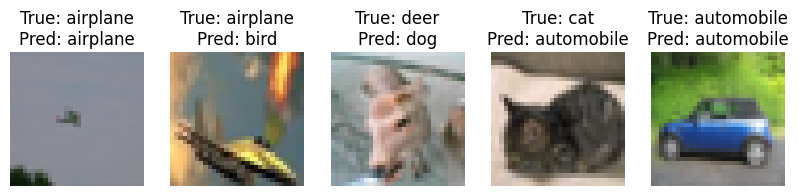

Confusion Matrix with Batch Normalization:


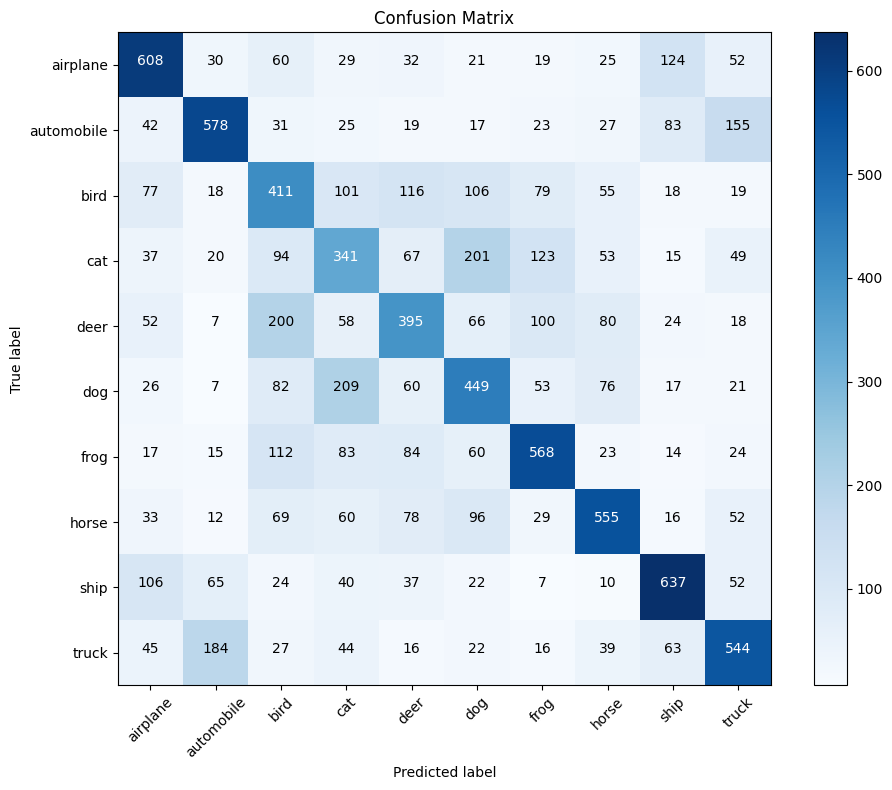

In [20]:
# Train and evaluate the network with batch normalization

print("Training the model with Batch Normalization")

model_bn, train_loss_bn, val_loss_bn, train_acc_bn, val_acc_bn = train_network(trainloader, valloader, use_batch_norm=True, n_epoch=25)

plot_loss(train_loss_bn, val_loss_bn)

plot_accuracy(train_acc_bn, val_acc_bn)


print("Evaluating the model with Batch Normalization")

test_accuracy_bn = evaluate_model(model_bn, testloader)

print(f'Test Accuracy with Batch Normalization: {test_accuracy_bn:.2f}%')

print("Random test images and predictions with Batch Normalization:")

plot_random_test_images(model_bn, testloader, testset)

print("Confusion Matrix with Batch Normalization:")

plot_confusion_matrix(model_bn, testloader, testset.classes)
